In [1]:
# Here is the imports
import os

os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
FLAGS = ["tensorboard"] # tensorboard, mixed_precision
from tensorflow import keras
import numpy as np
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
import segmentation_models as sm
import albumentations as A
sm.set_framework("tf.keras")
if "mixed_precision" in FLAGS:
    print(f"PreTrain: Using Mixed Policy float16")
    keras.mixed_precision.set_global_policy('mixed_float16')
# keras.mixed_precision.set_global_policy('mixed_float16') normally this would provide extra speed for the model
# but in the case of 1660ti gpus they seem like they have tensor cores even they don't thus it slows down the model use this on higher powered models
from matplotlib import pyplot as plt
AUTOTUNE = tf.data.AUTOTUNE
from keras_unet_collection import models
from tensorflow.keras.models import load_model
from keras_unet_collection import losses

Segmentation Models: using `tf.keras` framework.


In [2]:
# Dataset Constants
DATASET_PATH = "./recordbase"
TEST_DIR = "test"
BATCH_SIZE = 1
LR = 0.00005

RECORD_ENCODING_TYPE = "ZLIB" # none if no encoding is used

# Model Constants
BACKBONE = 'efficientnetb3'
# unlabelled 0, iskemik 1, hemorajik 2
CLASSES = ['iskemik', 'kanama']
MODEL_WEIGHT_PATH = "./models/13_09-18_28/weights_25.h5"

# Variables
test_dir = os.path.join(DATASET_PATH, TEST_DIR)

test_filenames = tf.io.gfile.glob(f"{test_dir}/*.tfrecords")


In [3]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        # if whole binary image is true plt shows it as whole image is false so for bypassing this issue we assing one pixels value to 0
        image[1,1] = 0 
        plt.imshow(image)
    plt.show()

def visualize_dataset(img, mask, classes):
    kwarg = {'image': img}
    for i in range(len(classes)):
        kwarg.update({classes[i] : mask[..., i].squeeze()})
    visualize(**kwarg)

# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [4]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)
    
def preprocessing_fn(image, mask):
    image = image/255.
    image = image.astype("float32")
    return image, mask

def parse_examples_batch(examples):
    feature_description = {
        'image/raw_image' : tf.io.FixedLenFeature([], tf.string),
        'label/raw' : tf.io.FixedLenFeature([], tf.string)
    }
    samples = tf.io.parse_example(examples, feature_description)
    return samples

def prepare_sample(features):
    image = tf.vectorized_map(lambda x: tf.io.parse_tensor(x, out_type = tf.uint8), features["image/raw_image"])
    label = tf.vectorized_map(lambda x: tf.io.parse_tensor(x, out_type = tf.float32), features["label/raw"])
    image, label = tf.vectorized_map(lambda x: tf.numpy_function(func=preprocessing_fn, inp=x, Tout=(tf.float32, tf.float32)), [image, label])
    return image, label

def prepare_sample_aug(features):
    image = tf.vectorized_map(lambda x: tf.io.parse_tensor(x, out_type = tf.uint8), features["image/raw_image"])
    label = tf.vectorized_map(lambda x: tf.io.parse_tensor(x, out_type = tf.float32), features["label/raw"]) # this was float64
    image, label = tf.vectorized_map(lambda x: tf.numpy_function(func=aug_fn, inp=x, Tout=(tf.uint8, tf.float32)), [image, label])
    image, label = tf.vectorized_map(lambda x: tf.numpy_function(func=preprocessing_fn, inp=x, Tout=(tf.float32, tf.float32)), [image, label])
    return image, label

def get_dataset_optimized(filenames, batch_size, shuffle_size, augment=True):
    record_dataset = tf.data.TFRecordDataset(filenames, compression_type=RECORD_ENCODING_TYPE, num_parallel_reads=AUTOTUNE)
    if shuffle_size > 0:
        record_dataset = record_dataset.shuffle(shuffle_size)
    record_dataset = (record_dataset
                    .batch(batch_size=batch_size)
                    .map(map_func=parse_examples_batch, num_parallel_calls=tf.data.experimental.AUTOTUNE))
    if augment:
        record_dataset = record_dataset.map(map_func=prepare_sample_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        record_dataset = record_dataset.map(map_func=prepare_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return record_dataset.prefetch(tf.data.experimental.AUTOTUNE)


In [5]:
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation

activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

#model = models.swin_unet_2d((512, 512, 3), filter_num_begin=64, n_labels=3, depth=3, stack_num_down=2, stack_num_up=2, 
#                            patch_size=(2, 2), num_heads=[4, 8, 8], window_size=[4, 2, 2, 2], num_mlp=512, 
#                            output_activation='Softmax', shift_window=True, name='swin_unet')

# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
# TODO redefine class weights
multi_focal_tversky = losses.multiclass_focal_tversky(alpha=0.7, gamma=4/3)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(), sm.metrics.FScore()]

# compile keras model with defined optimozer, loss and metrics
#model = load_model(MODEL_WEIGHT_PATH, custom_objects={'wrapper': multi_focal_tversky,'iou_score': sm.metrics.IOUScore(), 'f1-score': sm.metrics.FScore()})

model.compile(optim, multi_focal_tversky, metrics)

model.load_weights(MODEL_WEIGHT_PATH)

test_dataset = get_dataset_optimized(test_filenames, BATCH_SIZE, 128, augment=False)


2021-09-13 20:04:02.801971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-13 20:04:02.893485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-13 20:04:02.894885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-13 20:04:02.897579: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
202

2021-09-13 20:04:31.662778: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-13 20:04:36.136586: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202


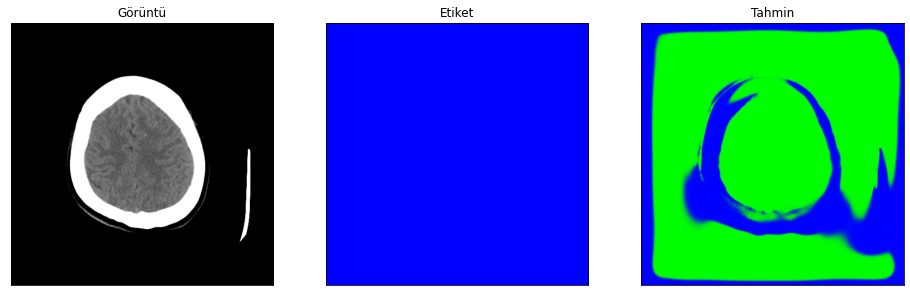

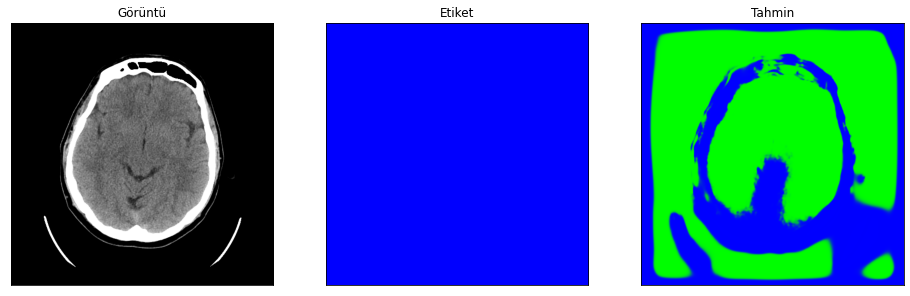

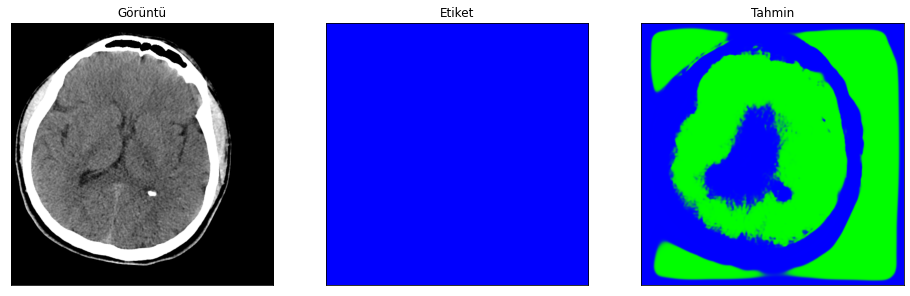

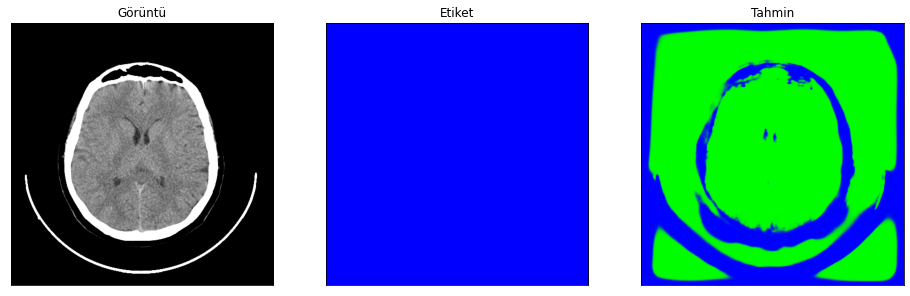

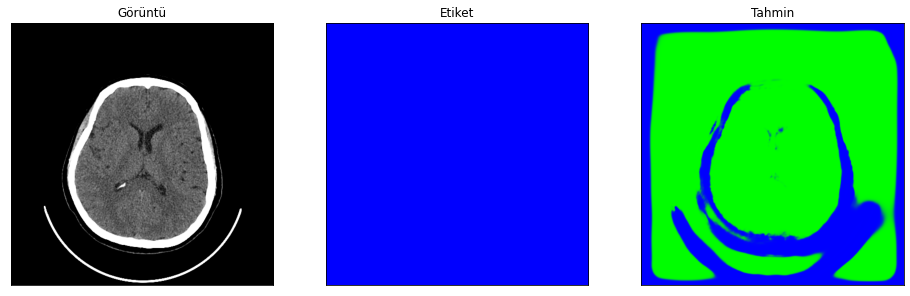

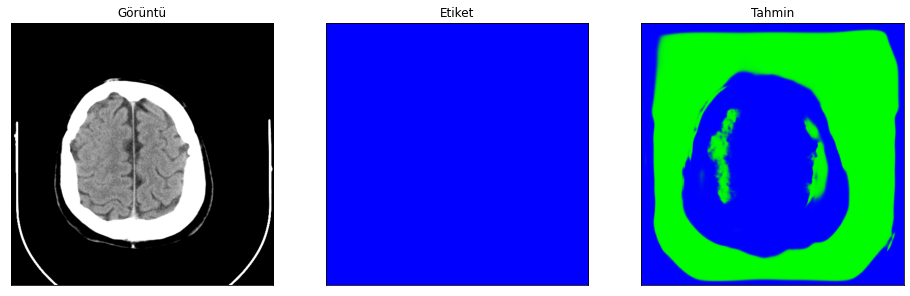

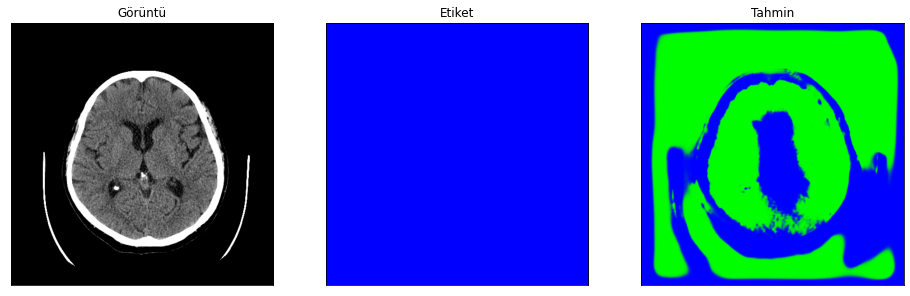

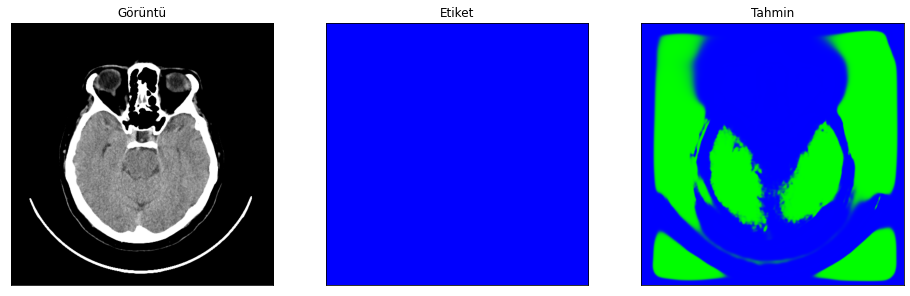

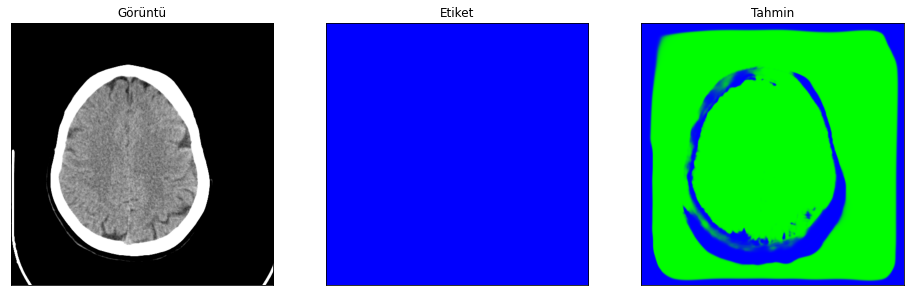

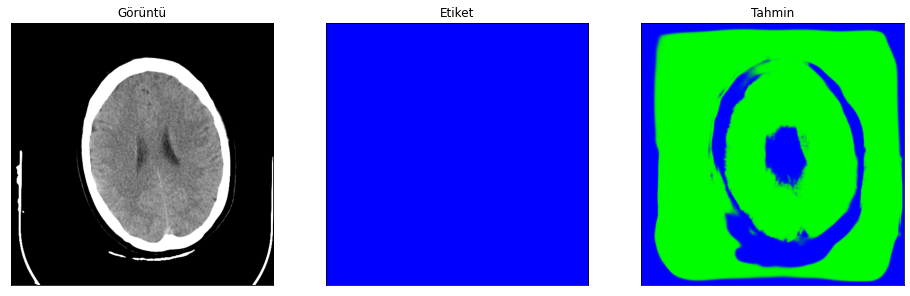

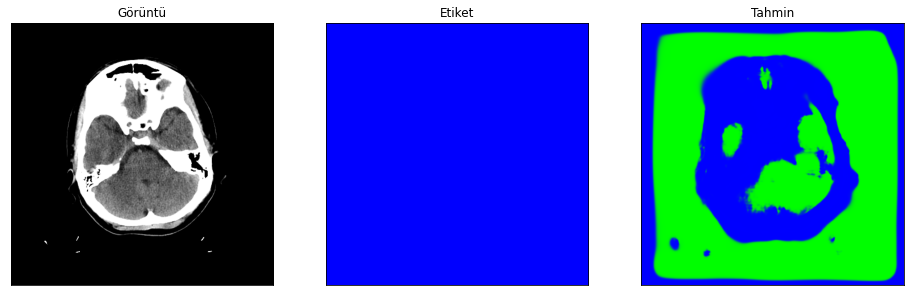

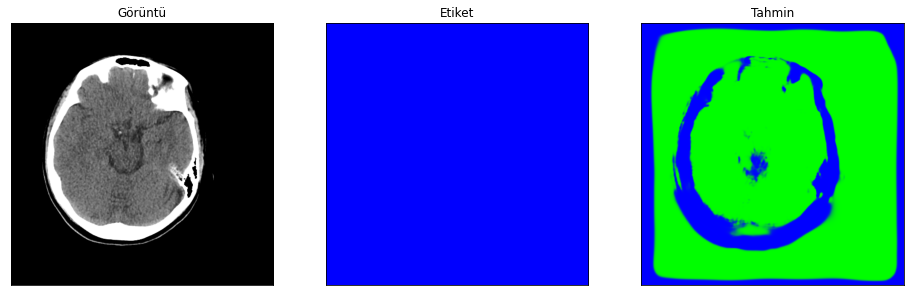

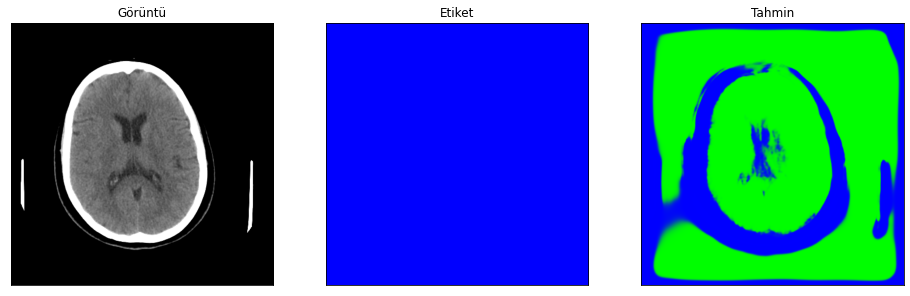

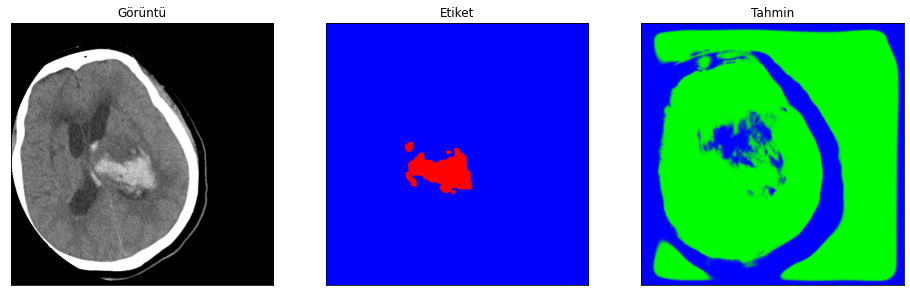

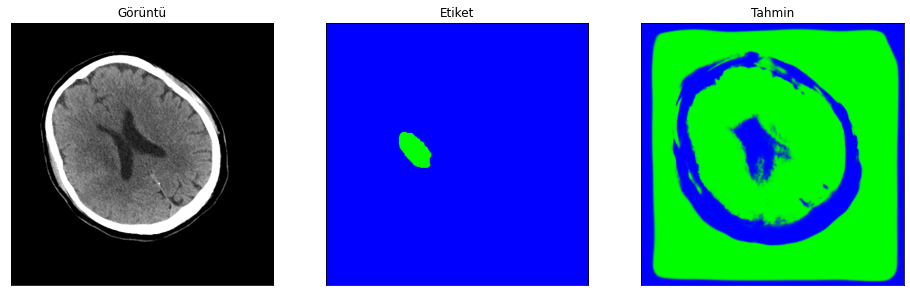

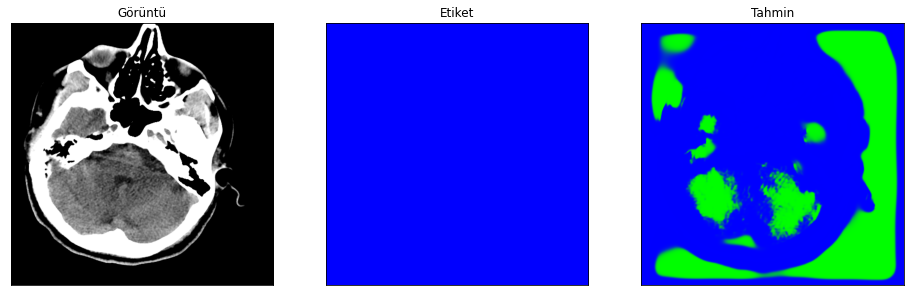

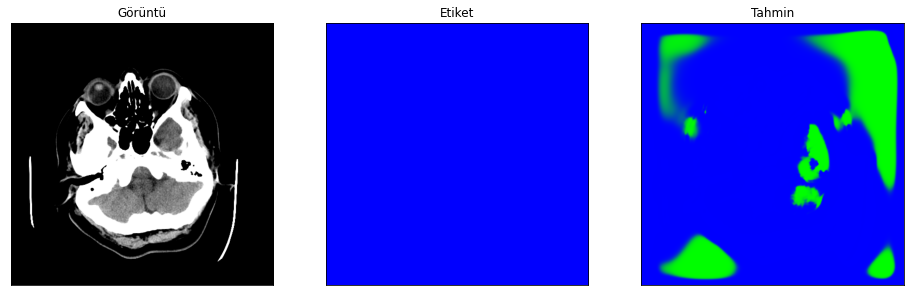

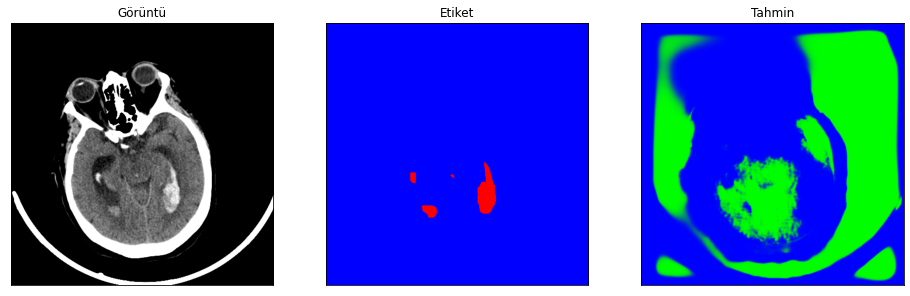

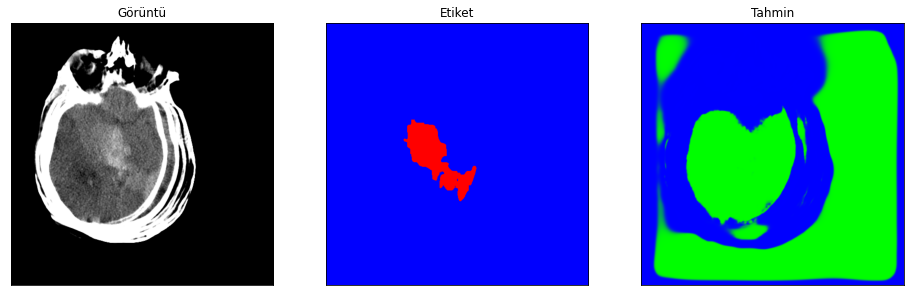

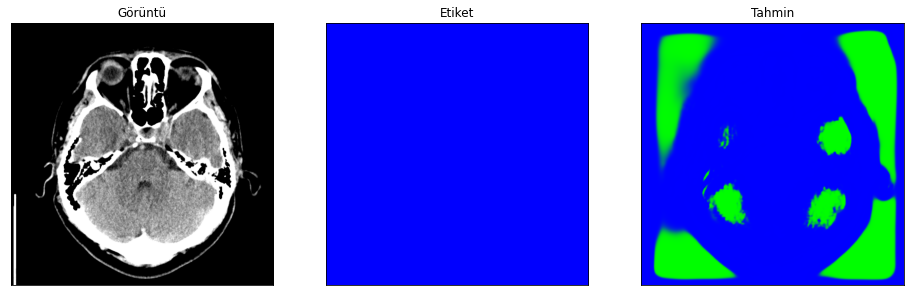

In [6]:
n = 20
n // BATCH_SIZE
test = test_dataset.take(n)
for i in test:
    for k in range(0, BATCH_SIZE):
        image = i[0][k].numpy()
        image = np.expand_dims(image, axis=0)
        #print(image)
        gt_mask = i[1][k].numpy()
        pred_mask = model.predict(image)
        visualize(
        Görüntü=denormalize(image.squeeze()),
        Etiket=gt_mask.squeeze(),
        Tahmin=pred_mask.squeeze(),
        )

In [ ]:
scores = model.evaluate(test_dataset)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))